# Spark ML для задачи оттока

Источник данных: [Kaggle](https://www.kaggle.com/sakshigoyal7/credit-card-customers)

Описания полей:

 | Название        | Описание                                                                                                                            |
 |:----------------|:------------------------------------------------------------------------------------------------------------------------------------|
 | CLIENTNUM       | Client number. Unique identifier for the customer holding the account                                                               |
 | Attrition_Flag  | Internal event (customer activity) variable                                                                                         |
 | Customer_Age    | Demographic variable - Customer's Age in Years                                                                                      |
 | Gender          | Demographic variable - M=Male, F=Female                                                                                             |
 | Dependent_count | Demographic variable - Number of dependents                                                                                         |
 | Education_Level | Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)               |
 | Marital_Status  | Demographic variable - Married, Single, Divorced, Unknown                                                                           |
 | Income_Category | Demographic variable - Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, > $120K, Unknown) |
 | Card_Category   | Product Variable - Type of Card (Blue, Silver, Gold, Platinum)                                                                      |
 | Months_on_book  | Period of relationship with bank                                                                                                    |

## Инициализация Spark сессии

Создаем Spark сессию для работы с данными. Настраиваем локальный режим с использованием всех доступных ядер процессора и устанавливаем уровень логирования WARN для уменьшения количества информационных сообщений.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

spark = (SparkSession
    .builder
    .master("local[*]")
    .appName("Spark ML Research")
    .config("spark.log.level", "WARN")
    .getOrCreate()
)

## Загрузка и знакомство с данными

## Проверка содержимого директории

Проверяем содержимое текущей директории, чтобы убедиться что файл с данными находится в нужном месте.

In [ ]:
!pwd

In [ ]:
!ls -la

## Загрузка данных

Загружаем CSV файл с банковскими данными в DataFrame. Используем опции для автоматического определения схемы данных и указания что первая строка содержит заголовки колонок.


In [ ]:
!ls -la data

In [ ]:
raw = (spark
    .read
    .option("header", "true")
    .option("inferSchema", "true")
    .csv("data/BankChurners.csv")
)

### Убираем первую и последние две колонки

## Очистка данных

Удаляем первую колонку (CLIENTNUM) и последние две колонки, которые не нужны для анализа. Отображаем первые 5 строк очищенного датасета.


In [ ]:
columns = raw.columns
columnsLen = len(columns)
colsToDrop = columns[0].split() + columns[columnsLen-2:columnsLen]

df = raw.drop(*colsToDrop)

df.show(5, False)

### Определяем типы колонок

## Анализ схемы данных

Выводим схему DataFrame чтобы понять структуру данных и типы колонок.


In [ ]:
df.printSchema()

## Форматированный вывод типов данных

Создаем удобочитаемый вывод типов данных всех колонок с выравниванием по правому краю.


In [ ]:
dt = df.dtypes
for r in dt:
    print(f"{r[0]:>25}\t{r[1]}")

## Подсчет типов данных

Группируем колонки по типам данных и подсчитываем количество колонок каждого типа (double, int, string).


In [ ]:
from itertools import groupby

dt.sort(key=lambda x: x[1])

for k, g in groupby(dt, lambda x: x[1]):
    print(k, len(list(g)))

### Проверим числовые колонки

## Выделение числовых колонок

Фильтруем колонки по типу данных и создаем список только числовых колонок (int и double) для дальнейшего анализа.


In [ ]:
numericColumns = list(
    map(
        lambda x: x[0], 
            filter(
                lambda x: x[1] == "double" or x[1] == "int", 
                df.dtypes
        )
    )
)

## Статистический анализ числовых данных

Выводим описательную статистику для всех числовых колонок: количество значений, среднее, стандартное отклонение, минимум, квартили и максимум.

In [ ]:
df.select(*numericColumns).summary().show()

## Визуализация распределения возраста клиентов

Создаем график распределения возраста клиентов. Группируем данные по возрасту, подсчитываем количество клиентов каждого возраста и строим линейный график.


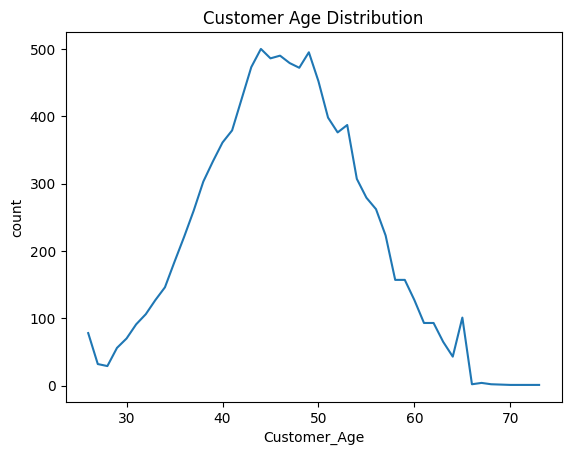

In [12]:
import matplotlib.pyplot as plt

age = df.groupBy("Customer_Age").count().orderBy("Customer_Age")
x_val = [val["Customer_Age"] for val in age.select("Customer_Age").collect()]
y_val = [val["count"] for val in age.select("count").collect()]

plt.plot(x_val, y_val)

plt.xlabel("Customer_Age")
plt.ylabel("count")
plt.title("Customer Age Distribution")

plt.show()

## Целевая колонка

## Создание целевой переменной

Преобразуем категориальную переменную "Attrition_Flag" в бинарную целевую переменную:  
0 для существующих клиентов,  
1 для ушедших клиентов.


In [13]:
dft = (df
    .withColumn(
        "target", 
        f.when(df["Attrition_Flag"] == "Existing Customer", 0).otherwise(1)
    )
)

dft.select("Attrition_Flag", "target").show(5, False)

+-----------------+------+
|Attrition_Flag   |target|
+-----------------+------+
|Existing Customer|0     |
|Existing Customer|0     |
|Existing Customer|0     |
|Existing Customer|0     |
|Existing Customer|0     |
+-----------------+------+
only showing top 5 rows


### Проверка сбалансированности данных

## Анализ баланса классов

Подсчитываем количество примеров каждого класса (ушедшие и существующие клиенты) для оценки сбалансированности данных.


In [14]:
dft.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|     1| 1627|
|     0| 8500|
+------+-----+



### Oversampling

## Подготовка к балансировке классов

Разделяем данные на два DataFrame по классам и вычисляем коэффициент для oversampling меньшинства (класс 1 - ушедшие клиенты).


In [15]:
df1 = dft.filter(dft["target"] == 1)
df0 = dft.filter(dft["target"] == 0)

df1count = df1.count()
df0count = df0.count()

int(df0count / df1count)

5

## Применение oversampling

Увеличиваем количество примеров меньшинства путем дублирования записей с использованием функции explode и массива литералов.


In [16]:
df1Over = (df1
    .withColumn(
        "dummy", 
        f.explode(f.array(*[f.lit(x) for x in range(int(df0count / df1count))])))
    .drop("dummy")
)

df1Over.show(10, False)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+
|Attrition_Flag   |Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|target|
+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+---------

## Объединение сбалансированных данных

Объединяем мажоритарный класс с увеличенным меньшинством и проверяем итоговый баланс классов.


In [17]:
data = df0.unionAll(df1Over)
data.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|     0| 8500|
|     1| 8135|
+------+-----+



## Работа с признаками

### Проверим корреляции числовых признаков

## Генерация пар колонок для корреляционного анализа

Создаем все возможные пары числовых колонок для вычисления корреляций между ними.


#### Вариант 1: DataFrameStatFunctions

## Вычисление корреляций с помощью DataFrameStatFunctions

Используем встроенный метод stat.corr() для вычисления корреляции Пирсона между парами колонок. Фильтруем пары с высокой корреляцией (>0.6).


In [18]:
from itertools import combinations

numericColumnsPairs = list(combinations(numericColumns, 2))
numericColumnsPairs

[('Customer_Age', 'Dependent_count'),
 ('Customer_Age', 'Months_on_book'),
 ('Customer_Age', 'Total_Relationship_Count'),
 ('Customer_Age', 'Months_Inactive_12_mon'),
 ('Customer_Age', 'Contacts_Count_12_mon'),
 ('Customer_Age', 'Credit_Limit'),
 ('Customer_Age', 'Total_Revolving_Bal'),
 ('Customer_Age', 'Avg_Open_To_Buy'),
 ('Customer_Age', 'Total_Amt_Chng_Q4_Q1'),
 ('Customer_Age', 'Total_Trans_Amt'),
 ('Customer_Age', 'Total_Trans_Ct'),
 ('Customer_Age', 'Total_Ct_Chng_Q4_Q1'),
 ('Customer_Age', 'Avg_Utilization_Ratio'),
 ('Dependent_count', 'Months_on_book'),
 ('Dependent_count', 'Total_Relationship_Count'),
 ('Dependent_count', 'Months_Inactive_12_mon'),
 ('Dependent_count', 'Contacts_Count_12_mon'),
 ('Dependent_count', 'Credit_Limit'),
 ('Dependent_count', 'Total_Revolving_Bal'),
 ('Dependent_count', 'Avg_Open_To_Buy'),
 ('Dependent_count', 'Total_Amt_Chng_Q4_Q1'),
 ('Dependent_count', 'Total_Trans_Amt'),
 ('Dependent_count', 'Total_Trans_Ct'),
 ('Dependent_count', 'Total_Ct_Chn

## Вывод высоких корреляций

Сортируем и выводим пары признаков с высокой корреляцией в порядке убывания значения корреляции.


In [19]:
corr = list(
    filter(
        lambda x: abs(x[2]) > 0.6, 
        map(lambda x: (x[0], x[1], data.stat.corr(x[0], x[1])), numericColumnsPairs)))

In [20]:
corr.sort(key=lambda x: x[2])
for i in reversed(corr):
    print(f"{i[0]:>25} {i[1]:>25}\t{i[2]}")

             Credit_Limit           Avg_Open_To_Buy	0.9952040726156252
          Total_Trans_Amt            Total_Trans_Ct	0.8053901681243807
             Customer_Age            Months_on_book	0.7805047706891143
      Total_Revolving_Bal     Avg_Utilization_Ratio	0.6946855441968229


## Альтернативный метод: создание полной матрицы корреляций

Создаем все возможные пары колонок включая самопары для построения полной корреляционной матрицы.


#### Вариант 2: Correlation

## Вычисление матрицы корреляций с помощью ML библиотеки

Используем VectorAssembler и Correlation из pyspark.ml для создания полной корреляционной матрицы всех числовых признаков.


In [21]:
numericColumnsPairsFull = list(map(lambda z: z[1], map(lambda x: [x, list(map(lambda y: (x, y), numericColumns))], numericColumns)))
numericColumnsPairsFull

[[('Customer_Age', 'Customer_Age'),
  ('Customer_Age', 'Dependent_count'),
  ('Customer_Age', 'Months_on_book'),
  ('Customer_Age', 'Total_Relationship_Count'),
  ('Customer_Age', 'Months_Inactive_12_mon'),
  ('Customer_Age', 'Contacts_Count_12_mon'),
  ('Customer_Age', 'Credit_Limit'),
  ('Customer_Age', 'Total_Revolving_Bal'),
  ('Customer_Age', 'Avg_Open_To_Buy'),
  ('Customer_Age', 'Total_Amt_Chng_Q4_Q1'),
  ('Customer_Age', 'Total_Trans_Amt'),
  ('Customer_Age', 'Total_Trans_Ct'),
  ('Customer_Age', 'Total_Ct_Chng_Q4_Q1'),
  ('Customer_Age', 'Avg_Utilization_Ratio')],
 [('Dependent_count', 'Customer_Age'),
  ('Dependent_count', 'Dependent_count'),
  ('Dependent_count', 'Months_on_book'),
  ('Dependent_count', 'Total_Relationship_Count'),
  ('Dependent_count', 'Months_Inactive_12_mon'),
  ('Dependent_count', 'Contacts_Count_12_mon'),
  ('Dependent_count', 'Credit_Limit'),
  ('Dependent_count', 'Total_Revolving_Bal'),
  ('Dependent_count', 'Avg_Open_To_Buy'),
  ('Dependent_count', '

## Вывод корреляционной матрицы

Выводим полную корреляционную матрицу в виде двумерного массива для дальнейшего анализа.


In [22]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

numericAssembler = VectorAssembler()\
    .setInputCols(numericColumns)\
    .setOutputCol("features")

numeric = numericAssembler.transform(data)
matrix = Correlation.corr(numeric, "features").head().asDict()['pearson(features)'].toArray().tolist()

25/09/17 19:10:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


## Обработка корреляционной матрицы

Создаем генератор для извлечения пар корреляций из матрицы с соответствующими названиями колонок.


In [23]:
matrix

[[1.0,
  -0.13575515707704905,
  0.780504770689084,
  -0.026525310066417403,
  0.13116552936201348,
  -0.019944405497176732,
  0.016657097778483475,
  -0.002841536593767456,
  0.016929170875654043,
  -0.020559135165498028,
  -0.06586475313340744,
  -0.07815083273365253,
  -0.016568818333932693,
  -0.010985827540562288],
 [-0.13575515707704905,
  1.0,
  -0.11728062823959522,
  -0.03266417786351196,
  -0.010657501150598976,
  -0.02566496168277401,
  0.06002070339266479,
  0.0018723592997836101,
  0.05981512203616065,
  -0.04794367154504479,
  0.00700430540503166,
  0.025513406218718206,
  -0.019666216088456825,
  -0.03300255953641679],
 [0.780504770689084,
  -0.11728062823959522,
  1.0,
  -0.017395648588812672,
  0.17573226369307368,
  -0.018581210990133486,
  0.01736017181943523,
  0.002027784037740437,
  0.017155177760641748,
  -0.016079093535360012,
  -0.05568529445298156,
  -0.05906597721356735,
  -0.021148786215887182,
  -0.018757073876222614],
 [-0.026525310066417403,
  -0.03266417

## Фильтрация высоких корреляций из матрицы

Фильтруем пары с высокой корреляцией (0.6 < |r| < 1) и приводим их к стандартному формату для сравнения.


In [24]:
def generate_cor_pairs(m, n):
    for x in range(0, len(m)):
        for y in range(0, len(m[0])):
            yield abs(matrix[x][y]), n[x][y]
            
cor_pairs = list(generate_cor_pairs(matrix, numericColumnsPairsFull))

## Отображение результатов второго метода

Сортируем и выводим результаты корреляционного анализа, полученные с помощью матричного метода.


In [25]:
corr2 = list(
    set(
        map(lambda x: (x[0], x[1][0], x[1][1]) if x[1][0] < x[1][1] else (x[0], x[1][1], x[1][0]),
            (filter(lambda x: 0.6 < x[0] < 1, cor_pairs)))))

## Сравнение методов

Проверяем пересечение результатов двух методов корреляционного анализа для валидации.


In [26]:
corr2.sort(key=lambda x: x[0])
for i in reversed(corr2):
    print(f"{i[1]:>25} {i[2]:>25}\t{i[0]}")

          Avg_Open_To_Buy              Credit_Limit	0.9952040726156179
          Total_Trans_Amt            Total_Trans_Ct	0.8053901681243786
             Customer_Age            Months_on_book	0.780504770689084
    Avg_Utilization_Ratio       Total_Revolving_Bal	0.6946855441968222


In [27]:
set(corr).intersection(set(corr2))

set()

## Исключение сильно коррелированных признаков

Создаем финальный список числовых признаков, исключив из него признаки с высокой корреляцией для предотвращения мультиколлинеарности.


#### Оставляем числовые колонки с низкой кореляцией

In [28]:
numericColumnsFinal = list(
    set(numericColumns) - set(map(lambda x: x[1], corr)))

numericColumnsFinal

['Total_Revolving_Bal',
 'Credit_Limit',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Dependent_count',
 'Months_Inactive_12_mon',
 'Customer_Age',
 'Total_Ct_Chng_Q4_Q1',
 'Total_Relationship_Count',
 'Contacts_Count_12_mon']

### Категориальные признаки

## Индексирование категориальных признаков

Используем StringIndexer для преобразования строковых категориальных признаков в числовые индексы. Исключаем целевую переменную "Attrition_Flag".


#### Индексируем строковые колонки

In [29]:
from pyspark.ml.feature import StringIndexer

stringColumns = list(
    filter(
        lambda x: x != "Attrition_Flag",
        map(lambda x: x[0], 
            filter(lambda x: x[1] == "string", data.dtypes))))

stringColumnsIndexed = list(map(lambda x: x + "_Indexed", stringColumns))

indexer = StringIndexer()\
    .setInputCols(stringColumns)\
    .setOutputCols(stringColumnsIndexed)

indexed = indexer.fit(data).transform(data)
indexed.show(5)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+--------------+-----------------------+----------------------+-----------------------+---------------------+
|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|target|Gender_Indexed|Education_Level_Indexed|Marital_Status_Indexed|Income_Category_Indexed|Card_Category_Indexed|
+-----------------+------------+------+---------------+---------------+---------

## One-Hot кодирование категориальных признаков

Применяем One-Hot кодирование к индексированным категориальным признакам для создания бинарных векторов, подходящих для машинного обучения.


#### Кодируем категориальные признаки

In [30]:
from pyspark.ml.feature import OneHotEncoder

catColumns = list(map(lambda x: x + "_Coded", stringColumnsIndexed))
    
encoder = OneHotEncoder()\
    .setInputCols(stringColumnsIndexed)\
    .setOutputCols(catColumns)

encoded = encoder.fit(indexed).transform(indexed)
encoded.show(5)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+--------------+-----------------------+----------------------+-----------------------+---------------------+--------------------+-----------------------------+----------------------------+-----------------------------+---------------------------+
|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|target|Gender_Indexed|Education_Level_Indexed|Marital_Stat

## Сборка признаков в векторное представление

Объединяем все числовые и закодированные категориальные признаки в один вектор признаков с помощью VectorAssembler.


### Собираем признаки в вектор

## Просмотр векторного представления

Выводим только колонку с векторами признаков для проверки правильности сборки.


In [31]:
from pyspark.ml.feature import VectorAssembler

featureColumns = numericColumnsFinal + catColumns

assembler = (VectorAssembler()
    .setInputCols(featureColumns)
    .setOutputCol("features")
)

assembled = assembler.transform(encoded)
assembled.show(5, truncate=False)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+--------------+-----------------------+----------------------+-----------------------+---------------------+--------------------+-----------------------------+----------------------------+-----------------------------+---------------------------+---------------------------------------------------------------------------------------------------------------------+
|Attrition_Flag   |Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_A

In [32]:
assembled.select("features").show(5, False)

+---------------------------------------------------------------------------------------------------------------------+
|features                                                                                                             |
+---------------------------------------------------------------------------------------------------------------------+
|(28,[0,1,2,3,4,5,6,7,8,9,12,17,23,25],[777.0,12691.0,1.335,1144.0,3.0,1.0,45.0,1.625,5.0,3.0,1.0,1.0,1.0,1.0])       |
|(28,[0,1,2,3,4,5,6,7,8,9,10,11,18,20,25],[864.0,8256.0,1.541,1291.0,5.0,1.0,49.0,3.714,6.0,2.0,1.0,1.0,1.0,1.0,1.0]) |
|(28,[1,2,3,4,5,6,7,8,11,17,22,25],[3418.0,2.594,1887.0,3.0,1.0,51.0,2.333,4.0,1.0,1.0,1.0,1.0])                      |
|(28,[0,1,2,3,4,5,6,7,8,9,10,12,19,20,25],[2517.0,3313.0,1.405,1171.0,4.0,4.0,40.0,2.333,3.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(28,[1,2,3,4,5,6,7,8,14,17,23,25],[4716.0,2.175,816.0,3.0,1.0,40.0,2.5,5.0,1.0,1.0,1.0,1.0])                         |
+---------------------------------------

## Нормализация признаков

Применяем MinMaxScaler для масштабирования всех признаков в диапазон [0,1]. Это важно для алгоритмов, чувствительных к масштабу данных.


### Нормализация

In [33]:
from pyspark.ml.feature import MinMaxScaler

scaler = (MinMaxScaler()
    .setInputCol("features")
    .setOutputCol("scaledFeatures")
)

scaled = scaler.fit(assembled).transform(assembled)

scaled.select("features", "scaledFeatures").show(5, False)

+---------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                             |scaledFeatures                                                                                                                                                                                                                |
+---------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Отбор наиболее важных признаков

Используем UnivariateFeatureSelector для автоматического отбора 75% наиболее значимых признаков на основе статистических тестов.


## Feature Selection (отбор признаков)

In [34]:
from pyspark.ml.feature import UnivariateFeatureSelector

selector = (UnivariateFeatureSelector()
    .setFeatureType("continuous")
    .setLabelType("categorical")
    .setSelectionMode("percentile")
    .setSelectionThreshold(0.75)
    .setFeaturesCol("scaledFeatures")
    .setLabelCol("target")
    .setOutputCol("selectedFeatures")
)

dataF = selector.fit(scaled).transform(scaled)

dataF.select("scaledFeatures", "selectedFeatures").show(5, False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaledFeatures                                                                                                                                                                                                                |selectedFeatures                                                                                                                                                                                                       |
+---------------------------------------------------------------------------------------------------------------------

## Моделирование

## Разделение данных на обучающую и тестовую выборки

Случайным образом разделяем данные в пропорции 70% для обучения и 30% для тестирования модели.


### Обучающая и тестовая выборки

## Проверка размеров выборок

Выводим количество записей в обучающей и тестовой выборках для контроля правильности разделения.


In [35]:
tt = dataF.randomSplit([0.7, 0.3])
training = tt[0]
test = tt[1]

In [36]:
print(f"training\t{training.count():>5}\ntest    \t{test.count():>5}")

training	11685
test    	 4950


## Обучение модели логистической регрессии

Создаем и обучаем модель логистической регрессии с регуляризацией Elastic Net. Настраиваем параметры: максимальное количество итераций, параметр регуляризации и смешивания L1/L2.


### Логистическая регрессия

In [37]:
from pyspark.ml.classification import LogisticRegression

lr = (LogisticRegression()
    .setMaxIter(1000)
    .setRegParam(0.2)
    .setElasticNetParam(0.8)
    .setFamily("binomial")
    .setFeaturesCol("selectedFeatures")
    .setLabelCol("target")
)

lrModel = lr.fit(training)

print(f"Coefficients: {lrModel.coefficients}\nIntercept: {lrModel.intercept}")

Coefficients: (21,[0,7],[-0.010627935382394564,-1.5608909147789582])
Intercept: 0.23424569658040023


## Анализ результатов обучения

Выводим метрики качества модели на обучающей выборке: точность (accuracy) и площадь под ROC-кривой (AUC).


### Training Summary

In [38]:
trainingSummary = lrModel.summary

print(f"accuracy: {trainingSummary.accuracy}")
print(f"areaUnderROC: {trainingSummary.areaUnderROC}")

accuracy: 0.7042362002567394


areaUnderROC: 0.7490359275196165


## Применение модели к тестовым данным

Применяем обученную модель к тестовой выборке для получения предсказаний и оценки качества на независимых данных.


### Проверяем модель на тестовой выборке

## Оценка качества на тестовой выборке

Вычисляем AUC-ROC для тестовой выборки с помощью BinaryClassificationEvaluator для оценки обобщающей способности модели.


In [39]:
predicted = lrModel.transform(test)

predicted.select("target", "prediction").show(10, False)

+------+----------+
|target|prediction|
+------+----------+
|0     |0.0       |
|0     |1.0       |
|0     |0.0       |
|0     |0.0       |
|0     |1.0       |
|0     |0.0       |
|0     |1.0       |
|0     |1.0       |
|0     |0.0       |
|0     |1.0       |
+------+----------+
only showing top 10 rows


In [40]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator().setLabelCol("target")

print(f"areaUnderROC: {evaluator.evaluate(predicted)}")

areaUnderROC: 0.7561606888962964


## Построение матрицы ошибок

Вычисляем элементы матрицы ошибок: True Positive, True Negative, False Positive, False Negative для детального анализа качества классификации.


#### Confusion Matrix (матрица ошибок)

* True Positive (TP) - label is positive and prediction is also positive
* True Negative (TN) - label is negative and prediction is also negative
* False Positive (FP) - label is negative but prediction is positive
* False Negative (FN) - label is positive but prediction is negative

In [41]:
tp = predicted.filter((f.col("target") == 1) & (f.col("prediction") == 1)).count()
tn = predicted.filter((f.col("target") == 0) & (f.col("prediction") == 0)).count()
fp = predicted.filter((f.col("target") == 0) & (f.col("prediction") == 1)).count()
fn = predicted.filter((f.col("target") == 1) & (f.col("prediction") == 0)).count()

print(f"Confusion Matrix:\n{tp:>4}\t{fp:>4}\n{fn:>4}\t{tn:>4}")

Confusion Matrix:
1304	 309
1115	2222


## Расчет метрик качества

Вычисляем основные метрики классификации: Accuracy (общая точность), Precision (точность положительного класса), Recall (полнота/чувствительность).


#### Accuracy, Precision, Recall

* Accuracy (доля правильных ответов) = TP + TN / TP + TN + FP + FN
* Precision (точность) = TP / TP + FP
* Recall (полнота) = TP / TP + FN

In [42]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Accuracy = {accuracy}")
print(f"Precision = {precision}")
print(f"Recall = {recall}")

Accuracy = 0.7123232323232324
Precision = 0.8084314941103534
Recall = 0.5390657296403473


## Настройка гиперпараметров модели

Используем grid search для автоматического подбора оптимальных гиперпараметров: параметр регуляризации, включение интерсепта и тип регуляризации (L1/L2/Elastic Net).


## Настраиваем модель (подбираем гиперпараметры)

## Анализ лучших параметров

Выводим все параметры лучшей модели, найденной в процессе grid search, для понимания оптимальной конфигурации.


In [43]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

paramGrid = (ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.1, 0.5])
    .addGrid(lr.fitIntercept, [False, True])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .build()
)

trainValidationSplit = (TrainValidationSplit()
    .setEstimator(lr)
    .setEvaluator(evaluator)
    .setEstimatorParamMaps(paramGrid)
    .setTrainRatio(0.7)
    .setParallelism(2)
)

model = trainValidationSplit.fit(dataF)

## Сохранение лучшей модели

Сохраняем лучшую модель, найденную в процессе grid search, для дальнейшего использования в pipeline.


In [44]:
param_map = model.bestModel.extractParamMap()
for i in param_map:
    print(f"{i.name:<16}\t{param_map[i]}")

aggregationDepth	2
elasticNetParam 	0.0
family          	binomial
featuresCol     	selectedFeatures
fitIntercept    	True
labelCol        	target
maxBlockSizeInMB	0.0
maxIter         	1000
predictionCol   	prediction
probabilityCol  	probability
rawPredictionCol	rawPrediction
regParam        	0.1
standardization 	True
threshold       	0.5
tol             	1e-06


In [45]:
bestML = model.bestModel

## Создание ML Pipeline

Объединяем все этапы предобработки данных и обучения модели в единый pipeline: индексирование, кодирование, сборка признаков, нормализация, отбор признаков и обучение модели.


## Собираем всё вместе (Pipeline)

1. Отобрали числовые признаки: numericColumnsFinal
2. Проиндексировали строковые признаки: indexer
3. Закодировали категориальные признаки: encoder
4. Собрали признаки в вектор: assembler
5. Нормализовали признаки: scaler
6. Провели отбор признаков: selector
7. Рассчитали модель: bestML 

## Обучение финального pipeline

Разделяем исходные данные заново и обучаем весь pipeline на свежих данных для получения финальной модели.


In [46]:
from pyspark.ml import Pipeline

pipeline = Pipeline().setStages([indexer, encoder, assembler, scaler, selector, bestML])

In [47]:
[trainingData, testData] = data.randomSplit([0.7, 0.3])

pipelineModel = pipeline.fit(trainingData)

## Сохранение финальной модели

Сохраняем обученный pipeline в файловую систему для последующего использования в продакшене. Модель включает все этапы предобработки и может применяться к новым данным.


## Сохраняем модель

In [48]:
pipelineModel.write().overwrite().save("models/pipelineModel")